In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import scipy.stats as st

In [2]:
# Set random seeds
RANDOM_SEED = 337310097361442377075356538299924202755
random.seed(RANDOM_SEED)
rng = np.random.default_rng(seed=RANDOM_SEED)

In [3]:
class Agent:
    """
    Agents with belief-holding, -sampling, and -updating behavior.
    
    Attributes:
    beliefs -- Numpy array of possible parameter values into which an agent may hold belief
    log_probs -- Numpy array current relative log-probabilities of each belief
    likelihood -- likelihood function used during Bayesian belief updating; added for potential future extension to changing tolerance (i.e., sigma)
    diary -- Array of past incoming information
    protocol -- Array of past outgoing information
    """
    
    def __init__(
            self,
            beliefs,
            log_priors,
            likelihood=st.norm(
                loc = 0, 
                scale = 5
                )
            ):
        """
        Initialize an agent capable of updating and sampling of a world model (= beliefs & log-probabilities of each belief).
        """

        assert len(beliefs) == len(log_priors)
        self.beliefs = np.copy(beliefs)
        self.log_probs = np.copy(log_priors)
        self.likelihood = likelihood
        self.diary = np.array([])
        self.protocol = np.array([])
     
    def set_updated_belief(self, incoming_info):
        """Bayesian update of the agent's belief AND fit of new likelihood function."""

        self.diary = np.append(self.diary, incoming_info)
        self.log_probs += self.likelihood.logpdf(x=self.beliefs-incoming_info)
        self.log_probs -= np.max(self.log_probs)  # subtract max for numerical stability
        #self.likelihood = st.fit(st.norm, logpdf_to_pdf(self.log_probs))

    def get_belief_sample(self, size=1):
        """Sample a belief according to world model."""

        probs = logpdf_to_pdf(self.log_probs)
        sample = np.random.choice(self.beliefs, size=size, p=probs)
        self.protocol = np.append(self.protocol, sample)
        return sample

    def __repr__(self):
        """Return a string representation of the agent."""

        return f"Agent(beliefs={self.beliefs}, log_probs={self.log_probs}, likelihood={self.likelihood}, diary={self.diary}, protocol={self.protocol})"


In [4]:
def logpdf_to_pdf(logprobs):
    """ 
    Returns array of relative log probabilities as normalized relative probabilities.
    
    Keyword arguments:
    logprobs -- array of log probabilities
    """
    probs = logprobs - np.max(logprobs) # shift logprobs to be >0 after exponentiation -- probably needed due to non-normalized log-space Bayesian update
    probs = np.exp(probs)
    return probs / np.sum(probs)


In [5]:
def build_random_network(N_agents, N_neighbours):
    """
    Build adjacency matrix of a weighted graph of N_agents, with random connections.
    At the start, each agent has, on average, 3 connections, each connection is bidirectional and of weight 1.
    """
    #size = (N_agents, N_agents)
    p = N_neighbours/(N_agents - 1)   # probability of connection; '-1' to exclude self-connections
    #network = rng.uniform(size=size)
    #network = np.where(network < p, 1, 0)
    #network = np.triu(network, k=1)   # remove self-connections
    #network2 = network + network.T
    #
    #return network2

    G = nx.gnp_random_graph(N_agents, p, seed=RANDOM_SEED).to_directed()
    return G #nx.adjacency_matrix(G).todense()


In [6]:
def network_dynamics(agents, G, world, h, r, t_end):
    """
    Simulate the dynamics of Graph.
    As of now, weights are constant, only beliefs change.

    Keyword arguments:
    agents -- list of agents, each having beliefs and nodes
    G -- networkx graph object (formerly adjacency matrix)
    world -- distribution providing stochastically blurred actual world state
    h -- rate of external information draw events
    r -- rate of edge information exchange events
    t_end -- end time of simulation
    """

    assert nx.number_of_nodes(G) == len(agents)
    
    N_nodes = nx.number_of_nodes(G)
    N_edges = nx.number_of_edges(G)
    t = 0
    N_events = 0
    
    while t < t_end:
        dt = st.expon.rvs(scale=1/(h+r), random_state=rng)
        t = t + dt
        N_events += 1
        event = rng.uniform()
        
        if event < N_nodes*h / (N_nodes*h+N_edges*r):
            # external information draw event
            agent = random.choice(agents)
            agent.set_updated_belief(
                world.get_belief_sample(size=1)
                )

        else:
            # edge event
            chatters = random.choice(list(G.edges()))
            # update each agent's log-probabilities with sample of edge neighbour's beliefs
            sample0 = agents[chatters[0]].get_belief_sample(size=1)
            sample1 = agents[chatters[1]].get_belief_sample(size=1)
            agents[chatters[0]].set_updated_belief(sample1)
            agents[chatters[1]].set_updated_belief(sample0)

    return (agents,
            G,
            world,
            N_events,
            t_end,
            )


In [7]:
def main(
        N_agents=100,
        N_neighbours=3,
        N_beliefs=1000,
        belief_min=-100,
        belief_max=100,
        log_priors = np.zeros(1000),
        likelihood = st.norm(loc=0, scale=5),
        world_dist = st.norm(loc=0, scale=5),
        h=1,
        r=1,
        t_max=1000,
        ):  
    """
    Execute program.
    Get all parameters and initialize agents (w. belief and log-prior distributions), network graph, and world distribution.
    Then, run simulation until t>=t_max and return simulation results.

    Keyword arguments:
    N_agents -- number of agents
    N_neighbours -- expected number of neighbours per agent 
    N_beliefs -- number of beliefs (= grid points) we consider
    belief_min -- minimum value with belief > 0
    belief_max -- maximum value with belief > 0
    world -- distribution providing stochastically blurred actual world state
    h -- world distribution sampling rate
    r -- edge neighbour's beliefs sampling rate
    t_max -- time after which simulation stops
    """

    assert N_beliefs == len(log_priors)

    beliefs = np.linspace(belief_min, belief_max, N_beliefs)
    agents = [Agent(beliefs, log_priors, likelihood) for i in range(N_agents)]
    G = build_random_network(N_agents, N_neighbours)
    world = Agent(
        beliefs=beliefs,
        log_priors=world_dist.logpdf(x=beliefs)
        )

    agents, G, world, N_events, t_end = network_dynamics(agents, G, world, h, r, t_max)

    return agents, G, beliefs, world, N_events, t_end


In [18]:
N_beliefs = 1000

agents, G, beliefs, world, N_events, t_end = main(
    N_agents = 100,
    N_neighbours = 3,
    N_beliefs = N_beliefs,
    belief_min = -100,
    belief_max = 100,
    log_priors = np.zeros(N_beliefs),
    likelihood = st.norm(loc=0, scale=5),
    world_dist = st.norm(loc=0, scale=5),
    h = 1,
    r = 0,
    t_max = 10000,
    )

print(f"Number of events: {N_events}")

Number of events: 10055


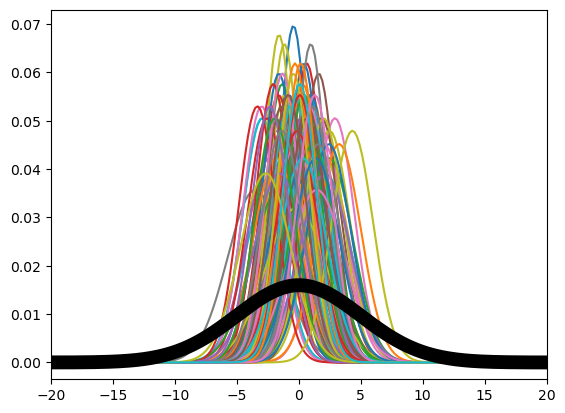

In [17]:
for i in range(len(agents)):
    plt.plot(agents[0].beliefs, logpdf_to_pdf(agents[i].log_probs))
    plt.xlim([-20, 20])
plt.plot(beliefs, logpdf_to_pdf(world.log_probs), color="black", linewidth=10, label="world")

(array([0.00053705, 0.        , 0.00080557, 0.00026852, 0.00107409,
        0.00080557, 0.00080557, 0.00134262, 0.00161114, 0.00214818,
        0.00134262, 0.00456489, 0.00322228, 0.00268523, 0.00241671,
        0.00617603, 0.00671308, 0.00644455, 0.00993536, 0.00483342,
        0.01208354, 0.01342616, 0.017454  , 0.01879662, 0.02389856,
        0.0244356 , 0.0185281 , 0.03114868, 0.03088016, 0.03705619,
        0.03678767, 0.03759324, 0.05048235, 0.02067628, 0.05155644,
        0.05880656, 0.06659373, 0.06793635, 0.06686226, 0.03490801,
        0.08001989, 0.07599204, 0.08565888, 0.08136251, 0.08028841,
        0.09183491, 0.04188961, 0.0859274 , 0.08834411, 0.08082546,
        0.07814023, 0.07840875, 0.08216808, 0.03678767, 0.07948284,
        0.07062158, 0.0673993 , 0.05826952, 0.06122327, 0.02389856,
        0.05182496, 0.04967678, 0.04511188, 0.04538041, 0.03437096,
        0.0359821 , 0.02067628, 0.02926902, 0.02282447, 0.0255097 ,
        0.02228742, 0.01960219, 0.01584286, 0.00

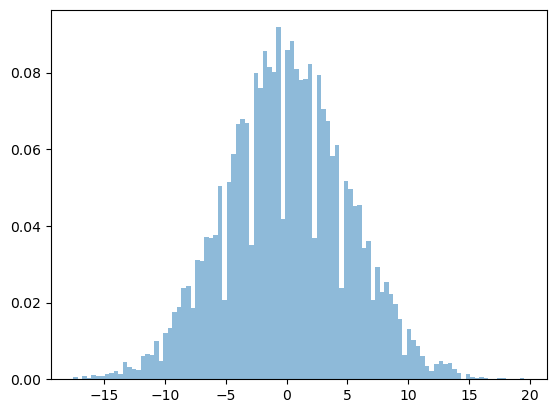

In [21]:
plt.hist(world.protocol, bins=100, density=True, alpha=0.5, label="world")